# Starting to make an ML model for row and track detection
Author: Alex Mazur

In this notebook you will find some preliminary research into model parameters for row and track detection.
The goal of this notebook is to expirament with various ways to relate image data to rows and tracks. 

In [1]:
# Imports required for computation
import cv2
import numpy as np 
from scipy.signal import argrelextrema
from sklearn.linear_model import HuberRegressor

# Other imports
import matplotlib.pyplot as plt
from timeit import default_timer as timer

This notebook is going to examine three images, you can see them below

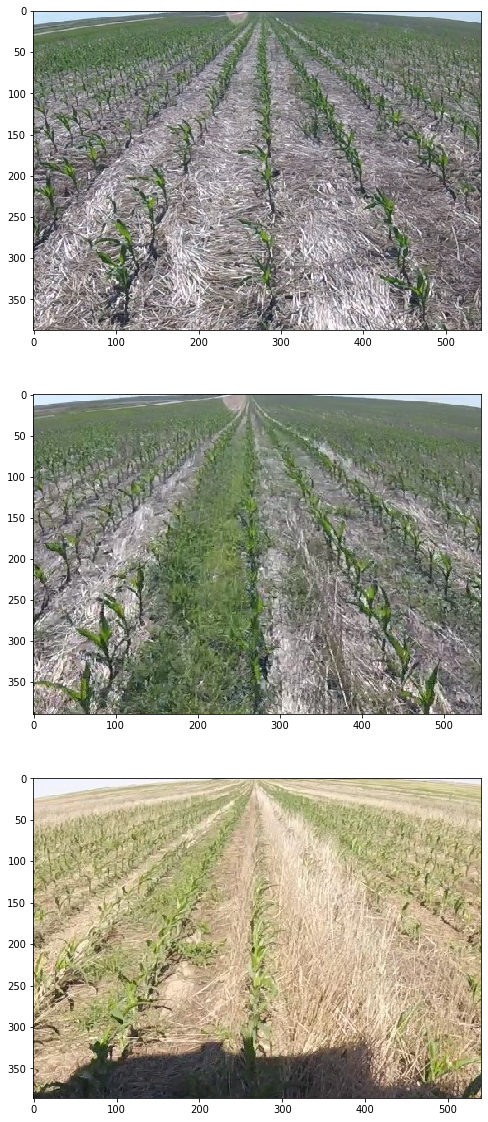

In [21]:
# CV2 reads the image in as BGR, so for plotting purposes we change to RGB
img1 = cv2.imread ("1.jpg", 1)
img2 = cv2.imread ("2.jpg", 1)
img3 = cv2.imread ("3.jpg", 1)
img1RGB = img1[...,::-1]
img2RGB = img2[...,::-1]
img3RGB = img3[...,::-1]
fig, axs = plt.subplots(3, figsize=(20,20))
axs[0].imshow (img1RGB)
axs[1].imshow (img2RGB)
axs[2].imshow (img3RGB)
plt.show ()

## Examining a single row in the image
If you examine a single row of pixels across an arbitrary image, then it might just look like noise on first glance. But, if you know you're loooking at something like crop rows on a farm, then it's a good bet that you might observe a pattern. The purpose of this notebook is to examine a method for using that pattern to determining which pixels are a crops and which pixels are rows. A quick note before we begin: this method is "dumb". It doesn't try to determine what the subject matter of the image is. It assumes that the image is of crop rows, and sometimes needs a single user input estimate on how wide the middle row is.

Below is some code that graphs a single row of pixels across image 1 (from above). Specifically it looks at row 326. 

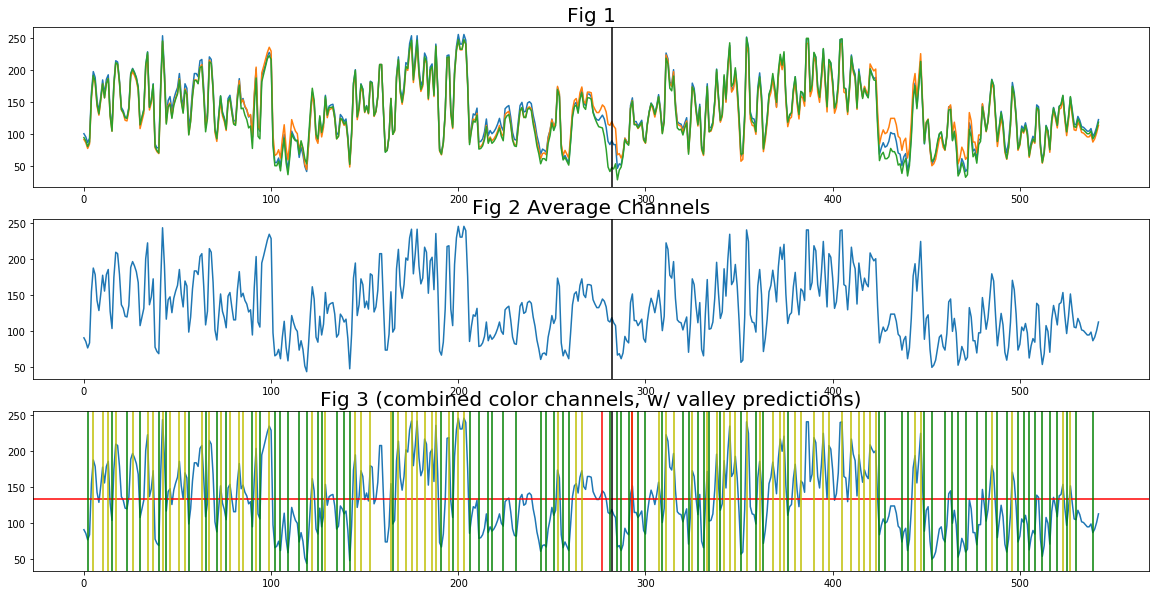

In [3]:
img1RGB = img1[...,::-1]

fig, axs = plt.subplots(3,figsize=(20,10))

# Plot a selected row
axs[0].plot (range (len (img1RGB[326])), img1RGB[326])

# Sum each color channel in the row, average the row
#  Could a color channel/combination be biases if the system know the plant color ahead of time?
summed = [int (pixel[1]) for pixel in img1RGB[326]]
avg = int (sum (summed) / len (summed))
summed = np.asarray (summed)
axs[1].plot (range (len (summed)), summed)
axs[2].plot (range (len (summed)), summed)
plt.axhline (y = avg, color = 'r')
valleyBound = avg - int (avg / 10) # Boundary for determining "valley"'s'
peakBound = avg + int (avg / 10) # Boundary for determining "peaks"''

# Find local maxima, keeping only those that meet our average based boundary
peaks = argrelextrema(summed, np.greater)
for peak in peaks[0]:
    if summed [peak] > peakBound:
        axs[2].axvline (x=peak, color='y')
xPeaks = [peak for peak in peaks[0] if summed[peak] > avg]

# Find local minima, keeping only those that meet our average based boundary
valleys = argrelextrema(summed, np.less)
for valley in valleys[0]:
    if summed[valley] < valleyBound:
        axs[2].axvline (x=valley, color='g')
xValleys = [valley for valley in valleys[0] if summed[valley] < avg]
        
# Determine the closest local maxima to the center of the image, these could denote the boundaries of the center row
lRowBound, rRowBound = None, None
for peak in xPeaks:
    if peak > 282:
        rRowBound = peak
        axs[2].axvline(x=lRowBound, color='r')
        axs[2].axvline(x=rRowBound, color='r')
        break
    else:
        lRowBound = peak

axs[0].axvline(x=282, color='k')
axs[1].axvline(x=282, color='k')
axs[2].axvline(x=282, color='k')
axs[0].set_title ("Fig 1", fontsize=20)
axs[1].set_title ("Fig 2 Average Channels", fontsize=20)
axs[2].set_title ("Fig 3 (combined color channels, w/ valley predictions)", fontsize=20)
plt.show ()

Observing the data above, we see a seemingly erratic line. Using SciPy's argrelextrema we can find points of local minima and maxima (fig 3 in green and yellow respectively). Plant's tend to be darker than the ground, and so points of local minima tend to be some sort of plant. Whereas points of maxima are good candidates for the ground itself. Other points tend to be some sort of boundary or noise. The idea here isn't to be necessarily perfect! If we do this for every row in the image we end up with a lot of data, which we can filter down to get a pretty decent result. 

The red lines in fig 3 denote two seperate things. The horizontal red line is the average of all the pixels values in this row. This serves as a cut off point to filter minima and maxima. For example, maxima below this line get ignored. The two vertical red lines are the closest maxima beneath and above the center of the row. Any minima between them are grouped as the middle crop row for this particular row of the image.

## Creating a function to apply the model to any image
This function puts it all together, and is more diagnostic than the one we can run on larger/production images. It's quite easy to understand. We reduce the row from 3 color channels to 1 by summing the channels together, average the reduced row, find local minima and maxima and remove outliers, then calculate the center boundaries, and repeat for each row of the image.

In [4]:
def predict (image, distance_out, distance_in): 
    midPx = int (len (image[0]) / 2)
    predictions = {"peaks" : [], "valleys" : [],  "middle" : [], "left" : [], "right" : []}
    summed = np.empty (len (image [0]), dtype=np.uint16)
    for row in range (len (image)):
        avg = 0
        for index, pixel in enumerate (image [row]):
            summed [index] = int (pixel [0]) + int (pixel [1]) + int (pixel [2])
            avg += summed [index]
        avg = int (avg / len (summed))
        valleyBound = avg - int (avg / 10)
        peakBound = avg + int (avg / 10)
        
        # Find the peaks and valleys
        valleys = argrelextrema(summed, np.less)
        peaks = argrelextrema(summed, np.greater)
        xValleys = [valley for valley in valleys[0] if summed[valley] < valleyBound]
        xPeaks = [peak for peak in peaks[0] if summed[peak] > peakBound]

        lRowBound, rRowBound = None, None
        for peak in xPeaks:
            if peak > midPx:
                rRowBound = peak
                break
            else:
                lRowBound = peak
        
        if lRowBound is not None and rRowBound is not None and row > distance_out and row < distance_in:
            predictions['middle'].append ([mid for mid in xValleys if mid > lRowBound and mid < rRowBound])
            predictions['left'].append ([left for left in xValleys if left < lRowBound - 25])
            predictions['right'].append ([right for right in xValleys if right > rRowBound + 25])
        else:
            predictions['middle'].append ([])
            predictions['left'].append ([])
            predictions['right'].append ([])
        predictions["peaks"].append (xPeaks)
        predictions["valleys"].append (xValleys)

    return predictions

## Applying the results to the image
Below is some code that stiches everything together, and applies some extra work on the center row to make a heading prediction. First the we make our predictions on the image by calling the function above. Then we plot where the prediction function thought the ground and plants are. Then we remove certain outliers based on assumed width of the center row (in pixels). Finally we apply a Huber Linear Regression model to the predicted center row. This get's us a line, which we then plot in white. 

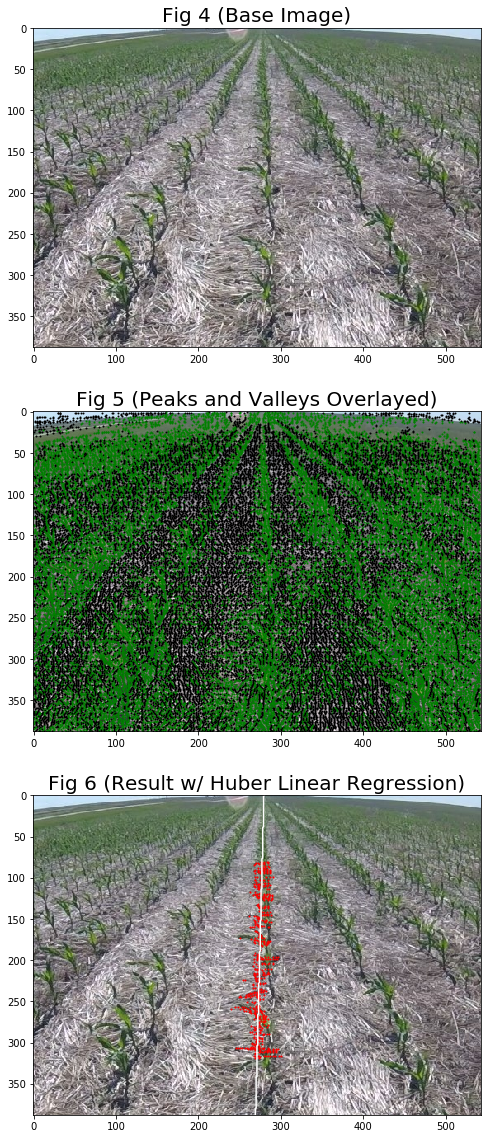

In [18]:
img1RGB = img1[...,::-1]
predictions = predict (img1, 80, 320)

fig, axs = plt.subplots(3,figsize=(20,20))
for row in range (len (img1RGB)):
    axs[1].scatter (predictions['valleys'][row], [row for _ in range (len (predictions['valleys'][row]))], color="g", s = 1)
    axs[1].scatter (predictions['peaks'][row], [row for _ in range (len (predictions['peaks'][row]))], color="black", s = 1)

xpoints, ypoints = [], []
for index, row in enumerate (predictions['middle']):
    if len (row) > 1:
        if row[-1] - row[0] > 50:
            continue
    for point in row:
        if index != 0 or point != 0:
            ypoints.append (point)
            xpoints.append ([index])
axs[2].scatter (ypoints, xpoints, color='r', s=1)
huber = HuberRegressor().fit(xpoints, ypoints)
huber.predict (xpoints)

huberX, huberY = [], []
for row in range (len (img1RGB)):
    huberX.append (int (huber.coef_ * row + huber.intercept_))
    huberY.append (row)

axs[0].imshow (img1RGB)
axs[1].imshow (img1RGB)
axs[2].imshow (img1RGB)

axs[2].plot (huberX, huberY, color='w')
axs[0].set_title ("Fig 4 (Base Image)", fontsize=20)
axs[1].set_title ("Fig 5 (Peaks and Valleys Overlayed)", fontsize=20)
axs[2].set_title ("Fig 6 (Result w/ Huber Linear Regression)", fontsize=20)
plt.show ()

## Testing The Model With Thick Same-Color-Weeds
Telling apart certain very similar aspects of an image is really hard for computers. In the image below we observer that between the center and left of center row there exists a group of thick weeds. These weeds are also unfortunately the same color as the center row. This example illustrates why we assume a row size. We can throw out pixel rows that predict across the enter chunk of plants. This also shows why we use Huber Linear Regression, and not just a standard Linear Regression model. Huber Linear Regression is good at dealing with outliers. Since we have so many points of data, we are able to remove and ignore many outliers while still getting a decent result!

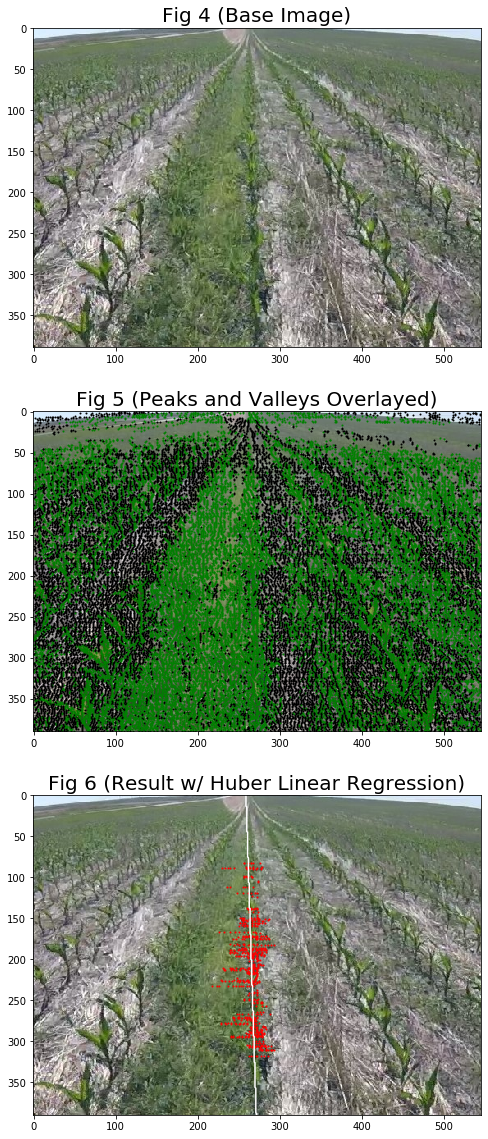

In [19]:
img2RGB = img2[...,::-1]
predictions = predict (img2, 80, 320)

fig, axs = plt.subplots(3,figsize=(20,20))
for row in range (len (img2RGB)):
    axs[1].scatter (predictions['valleys'][row], [row for _ in range (len (predictions['valleys'][row]))], color="g", s = 1)
    axs[1].scatter (predictions['peaks'][row], [row for _ in range (len (predictions['peaks'][row]))], color="black", s = 1)

xpoints, ypoints = [], []
for index, row in enumerate (predictions['middle']):
    if len (row) > 1:
        if row[-1] - row[0] > 50:
            continue
    for point in row:
        if index != 0 or point != 0:
            ypoints.append (point)
            xpoints.append ([index])
axs[2].scatter (ypoints, xpoints, color='r', s=1)
huber = HuberRegressor().fit(xpoints, ypoints)
huber.predict (xpoints)

huberX, huberY = [], []
for row in range (len (img2RGB)):
    huberX.append (int (huber.coef_ * row + huber.intercept_))
    huberY.append (row)

axs[0].imshow (img2RGB)
axs[1].imshow (img2RGB)
axs[2].imshow (img2RGB)

axs[2].plot (huberX, huberY, color='w')
axs[0].set_title ("Fig 4 (Base Image)", fontsize=20)
axs[1].set_title ("Fig 5 (Peaks and Valleys Overlayed)", fontsize=20)
axs[2].set_title ("Fig 6 (Result w/ Huber Linear Regression)", fontsize=20)
plt.show ()

## Testing the model with on a bright image with thick off-color-weeds
Bright images are no problem for this model either. Because we use averages to determine the cutoff points for minima and maxima, we can transition from bright to dark images frame by frame with no issues or tuning required. This model can also handle images that have different brightness levels in different vertical chunks. Differening brightness horizontally might be interesting to explore.

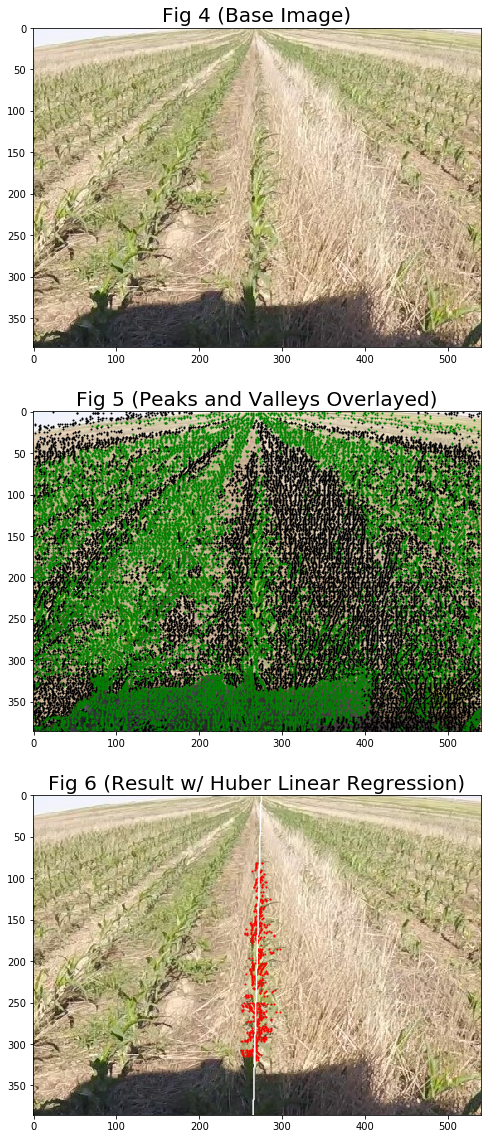

In [20]:
img3RGB = img3[...,::-1]
predictions = predict (img3, 80, 320)

fig, axs = plt.subplots(3,figsize=(20,20))
for row in range (len (img3RGB)):
    axs[1].scatter (predictions['valleys'][row], [row for _ in range (len (predictions['valleys'][row]))], color="g", s = 1)
    axs[1].scatter (predictions['peaks'][row], [row for _ in range (len (predictions['peaks'][row]))], color="black", s = 1)

xpoints, ypoints = [], []
for index, row in enumerate (predictions['middle']):
    if len (row) > 1:
        if row[-1] - row[0] > 50:
            continue
    for point in row:
        if index != 0 or point != 0:
            ypoints.append (point)
            xpoints.append ([index])
axs[2].scatter (ypoints, xpoints, color='r', s=1)
huber = HuberRegressor().fit(xpoints, ypoints)
huber.predict (xpoints)

huberX, huberY = [], []
for row in range (len (img3RGB)):
    huberX.append (int (huber.coef_ * row + huber.intercept_))
    huberY.append (row)

axs[0].imshow (img3RGB)
axs[1].imshow (img3RGB)
axs[2].imshow (img3RGB)

axs[2].plot (huberX, huberY, color='w')
axs[0].set_title ("Fig 4 (Base Image)", fontsize=20)
axs[1].set_title ("Fig 5 (Peaks and Valleys Overlayed)", fontsize=20)
axs[2].set_title ("Fig 6 (Result w/ Huber Linear Regression)", fontsize=20)
plt.show ()

## Closing remarks
This method is really promising. It's in an early stage of development, with many possible routes to explore. Some ideas are grouping algorithms, better tuned linear regression, better minima and maxima functions, etc. This method is also fast, and can very easily be multi-processed since each row is processed without context of any other row. I would be excited to hear about progress with this method, as over the semester nothing has excited quite as much as this one.

Below this I've also included some OpenCV 2 code that takes a video and makes predictions on it. It will run terribly slow in this notebook, so please don't run it here. On my personal desktop, with a very old GPU, it processed a 6 minute 1080p video in about 30 minutes. Translating this into a faster language (C, C++, etc.) and adding multi-processing could easily speed this method up to, I think, real time 30fps. Depending on your GPU. Anyways, here's the video processing code: 

In [ ]:
# The streamlined prediction function
def predict (image, distance_out, distance_in): 
    midPx = int (len (image[0]) / 2)
    predictions = []
    summed = np.empty (len (image [0]), dtype=np.uint16)
    for row in range (len (image)):
        avg = 0
        for index, pixel in enumerate (image [row]):
            summed [index] = int (pixel [0]) + int (pixel [1]) + int (pixel [2])
            avg += summed [index]
        avg = int (avg / len (summed))
        valleyBound = avg - int (avg / 10)
        peakBound = avg + int (avg / 10)
        
        # Find the peaks and valleys
        valleys = argrelextrema(summed, np.less)
        peaks = argrelextrema(summed, np.greater)
        xValleys = [valley for valley in valleys[0] if summed[valley] < valleyBound]
        xPeaks = [peak for peak in peaks[0] if summed[peak] > peakBound]

        lRowBound, rRowBound = None, None
        for peak in xPeaks:
            if peak > midPx:
                rRowBound = peak
                break
            else:
                lRowBound = peak
        
        if lRowBound is not None and rRowBound is not None and row > distance_out and row < distance_in:
            predictions.append ([mid for mid in xValleys if mid > lRowBound and mid < rRowBound])
        else:
            predictions.append ([])

    return predictions

# Make predictions on a section of the full image (speed), draw the full image, write to file
def videoCrop (toCrop, outName, x = 0, y = 0, h = None, w = None, debug = 0):
    
    # Video in streamer
    video = cv2.VideoCapture(toCrop)
    
    # Video Meta-data
    w_frame, h_frame = int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps, frames = video.get(cv2.CAP_PROP_FPS), video.get(cv2.CAP_PROP_FRAME_COUNT)
    
    if h == None:
        h = h_frame
    if w == None:
        w = w_frame
        
    width = w - x
    height = h - y
    row_px_width = 100
    
    print ("Video is being cropped to: " + str (width) + " by " + str (height))
    
    out = cv2.VideoWriter(outName, -1, fps, (w_frame, h_frame))
    
    prev = 0
    frame_count = 0
    while (video.isOpened ()):
        ret, frame = video.read ()
        
        frame_count += 1
        
        if ret:
            crop_frame = frame[y:h, x:w]
            predictions = predict (crop_frame, 10, 420)
            xpoints, ypoints = [], []
            for index, row in enumerate (predictions):
                if len (row) > 1:
                    if row[-1] - row[0] > row_px_width:
                        continue
                for point in row:
                    if index != 0 or point != 0:
                        ypoints.append (point)
                        xpoints.append ([index])
            huber = HuberRegressor().fit(xpoints, ypoints)
            huber.predict (xpoints)
            
            for index, row in enumerate (predictions):
                if len (row) > 1:
                    if row[-1] - row[0] > row_px_width:
                        continue
                for point in row:
                    cv2.circle(crop_frame, (point, index), radius=2, color=(0, 0, 255), thickness=-1)
            cv2.line(crop_frame, (int(huber.intercept_), 0), (int(huber.coef_*height+huber.intercept_), height), (0, 255, 0), thickness=2)
            
            out.write (frame)
            per = int (frame_count * 100 / frames)
            if debug >= 1 and per != prev:
                prev = per
                print (outName + " " + str (per) + "%")
            
            if debug >= 2:
                cv2.imshow('frame', frame)
                cv2.imshow('croped', crop_frame)
            
            if cv2.waitKey (1) & 0xFF == ord('q'):
                break
        else:
            break
    
    video.release()
    out.release()
    cv2.destroyAllWindows()
    print ("Finished writing!")

In [ ]:
# Those cropping values can and should be tuned for each image dep
videoCrop ('write_input_here.mp4', 'output_name_here.mp4',  x = 448, y = 550, w = 1472, debug = 1)